<a href="https://colab.research.google.com/github/FuturisticLover123/InnowiseInternship/blob/main/task1/ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import boto3
from dotenv import load_dotenv
import io 
import pandas as pd

load_dotenv()

YC_ACCESS_KEY_ID = os.getenv("YC_ACCESS_KEY_ID")
YC_SECRET_ACCESS_KEY = os.getenv("YC_SECRET_ACCESS_KEY")
YC_ENDPOINT_URL = os.getenv("YC_ENDPOINT_URL")
YC_BUCKET_NAME = os.getenv("YC_BUCKET_NAME")

In [2]:
session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=YC_ENDPOINT_URL,
    aws_access_key_id=YC_ACCESS_KEY_ID,
    aws_secret_access_key=YC_SECRET_ACCESS_KEY
)

In [3]:
import gzip

file_names = ["item_categories.csv.gzip", "items.csv.gzip", "sales_train.csv.gzip", "sample_submission.csv.gzip", "shops.csv.gzip", "test.csv.gzip" ]
data_location = "compressed_data/"

data_storage = dict()
for file_name in file_names:
    response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'{data_location}{file_name}')
    data_storage[file_name[: len(file_name) - 9]] = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')

In [4]:
train = data_storage["sales_train"]

In [5]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [6]:
%pip install pandas seaborn matplotlib numpy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

The objective is to predict sales for the shops listed in the `test` dataset. Globally, we are not concerned with shops from the `train` dataset that do not appear in `test`.

These shops would introduce unnecessary dependencies and increase data noise. Therefore, they can be safely removed from the training data.

In [9]:
train = train[data_storage["sales_train"]['shop_id'].isin((data_storage["test"])['shop_id'].unique())]
set(train["shop_id"].unique()).difference(set(data_storage["test"]["shop_id"].unique()))

set()

In [10]:
filtered_train = train[(0 <= train['item_cnt_day'])]

We are removing negative sales transactions as they represent either data collection errors or product returns. Since our goal is to predict **gross sales** volume (the total number of items sold), these transactions do not align with our objective and would introduce noise into the model.

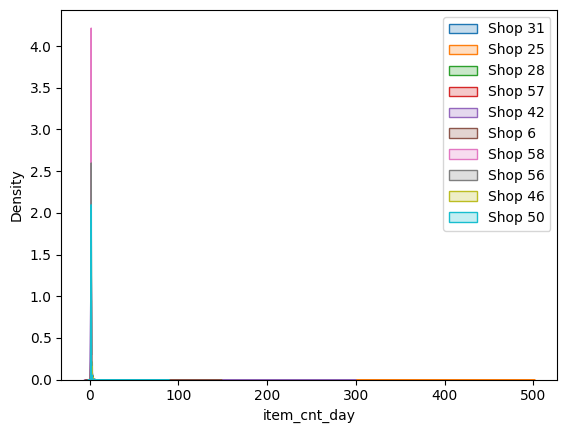

In [11]:
sample_shops = train['shop_id'].value_counts().index[:10]
for shop in sample_shops:
    sns.kdeplot(data=train[train['shop_id'] == shop], x='item_cnt_day', fill=True, label=f'Shop {shop}')

plt.legend()
plt.show()

Different shops exhibit unique peaks in their sales distributions. To handle outliers, we need to remove large values on a **per-shop basis**, rather than globally. This approach accounts for each shop's distinct sales pattern, ensuring that legitimate high-volume sales for a popular store are not mistakenly treated as anomalies, while genuine outliers for a smaller store are properly identified and removed.

In [12]:
def remove_outliers_by_shop(df, column='item_cnt_day'):
    cleaned_dfs = []
    for shop_id in df['shop_id'].unique():
        shop_data = df[df['shop_id'] == shop_id].copy()
        
        if len(shop_data) < 10:
            cleaned_dfs.append(shop_data)
            continue
        
        Q1 = shop_data[column].quantile(0.25)
        Q3 = shop_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        shop_data_cleaned = shop_data[(shop_data[column] >= lower_bound) & 
                                      (shop_data[column] <= upper_bound)]
        
        cleaned_dfs.append(shop_data_cleaned)
    
    return pd.concat(cleaned_dfs, ignore_index=True)

sales_train_cleaned = remove_outliers_by_shop(data_storage["sales_train"], 'item_cnt_day')
print("Data size after removing outliers:", sales_train_cleaned.shape)

print("Removed:", len(data_storage["sales_train"]) - len(sales_train_cleaned))



Data size after removing outliers: (2632181, 6)
Removed: 303668


### Data Loss Impact

A **10% data loss** has occurred during the cleaning process. This could be a significant amount of data, potentially impacting the model's performance by reducing the sample size and possibly introducing bias if the removed data points were not random. This loss should be carefully evaluated to determine its effect on the final model.

In [13]:
%pip install scikit-learn
from sklearn.ensemble import IsolationForest  

Note: you may need to restart the kernel to use updated packages.


In [14]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
filtered_train['anomaly'] = iso_forest.fit_predict(filtered_train[['item_cnt_day']].values)
sales_train_cleaned = filtered_train[filtered_train['anomaly'] == 1].copy()

/tmp/ipykernel_200800/2429495425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['anomaly'] = iso_forest.fit_predict(filtered_train[['item_cnt_day']].values)


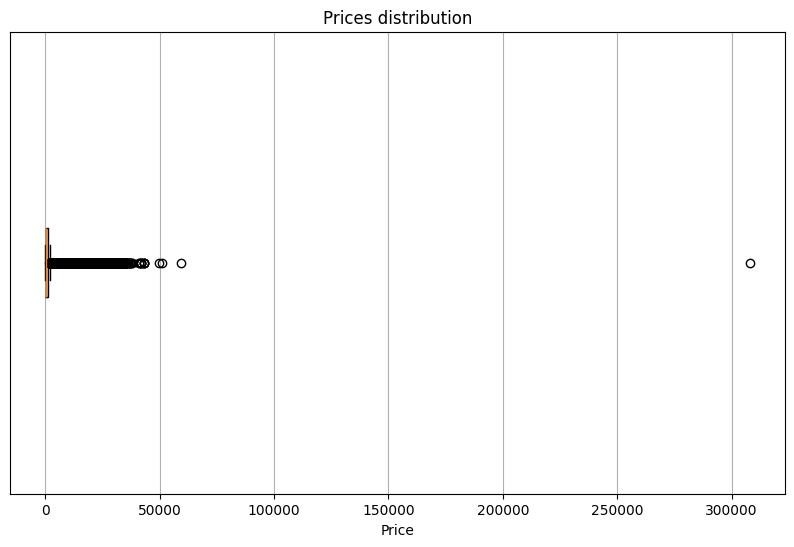

In [15]:
plt.figure(figsize=(10, 6))
plt.boxplot(sales_train_cleaned['item_price'], vert=False)
plt.title('Prices distribution')
plt.xlabel('Price')
plt.yticks([])
plt.grid(True)

In [16]:
upper_quantile = sales_train_cleaned['item_price'].quantile(0.99)
sales_train_filtered = sales_train_cleaned[sales_train_cleaned['item_price'] <= upper_quantile]


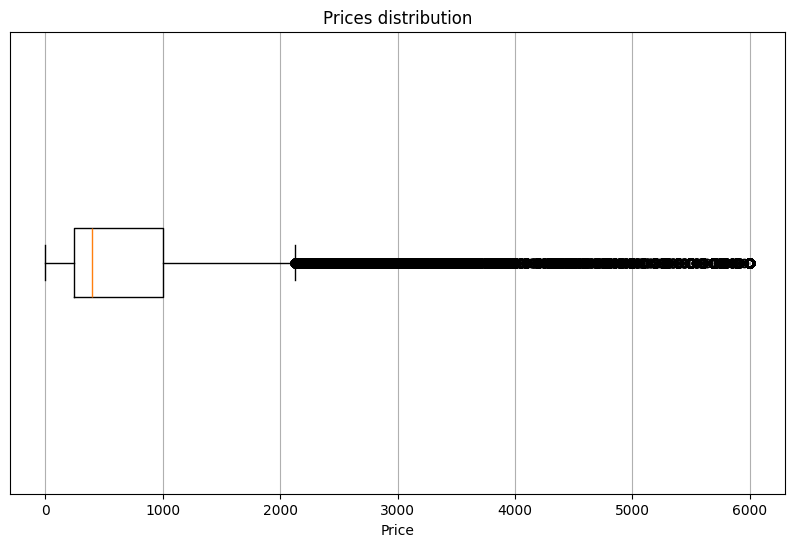

In [17]:
plt.figure(figsize=(10, 6))
plt.boxplot(sales_train_filtered['item_price'], vert=False)
plt.title('Prices distribution')
plt.xlabel('Price')
plt.yticks([])
plt.grid(True)

<Axes: xlabel='item_price', ylabel='Density'>

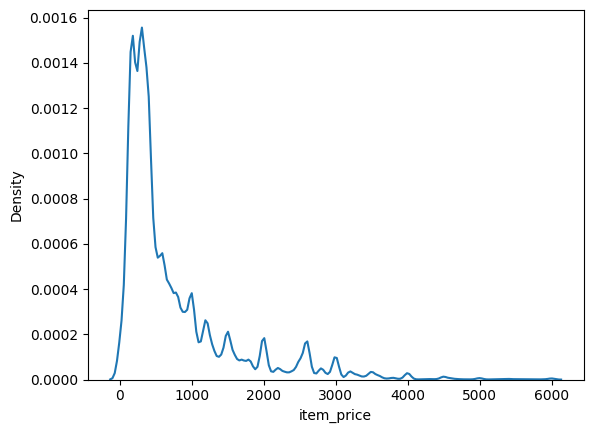

In [18]:
sns.kdeplot(sales_train_filtered['item_price'])

In [19]:
sales_train_filtered.drop(columns=['anomaly'], inplace=True)

/tmp/ipykernel_200800/3443905947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_train_filtered.drop(columns=['anomaly'], inplace=True)


# Shops

Some duplicates found in "shops"

    !Якутск Орджоникидзе, 56 фран
    !Якутск ТЦ "Центральный" фран
    Жуковский ул. Чкалова 39м
    РостовНаДону ТРК "Мегацентр Горизонт" Островной	

Fixing it

In [20]:
sales = train[train['item_cnt_day'] > 0].copy()

sales.loc[sales.shop_id == 0, 'shop_id'] = 57
data_storage['test'].loc[data_storage['test'].shop_id == 0, 'shop_id'] = 57


sales.loc[sales.shop_id == 1, 'shop_id'] = 58
data_storage['test'].loc[data_storage['test'].shop_id == 1, 'shop_id'] = 58

sales.loc[sales.shop_id == 10, 'shop_id'] = 11
data_storage['test'].loc[data_storage['test'].shop_id == 10, 'shop_id'] = 11

sales.loc[sales.shop_id == 39, 'shop_id'] = 40
data_storage['test'].loc[data_storage['test'].shop_id == 39, 'shop_id'] = 40

Adding categirical features shop_city and  shop_type to shops

In [21]:
data_storage["shops"]['shop_city'] = data_storage["shops"]['shop_name'].apply(lambda x: x.split()[0])
data_storage["shops"]['shop_type'] = data_storage["shops"]['shop_name'].apply(lambda x: x.split()[1])

replacing unknown catigories with "other"

In [22]:
values_to_keep =['ТЦ', 'ТРК', 'ТРЦ', 'Торговля', 'ЧС', '"Распродажа"', 'МТРЦ', 'Магазин', 'ТК','склад']

data_storage["shops"].loc[~data_storage["shops"]['shop_type'].isin(values_to_keep), 'shop_type'] = 'other'

In [23]:
data_storage["shops"]['shop_type'].unique()

array(['other', 'ТЦ', 'ТРК', 'ТРЦ', 'Торговля', 'ЧС', '"Распродажа"',
       'МТРЦ', 'Магазин', 'ТК', 'склад'], dtype=object)

# item categories

Adding categiries to items

In [24]:
data_storage["item_categories"]['split'] = data_storage["item_categories"]['item_category_name'].str.split('-')
data_storage["item_categories"]['item_category_type'] = data_storage["item_categories"]['split'].map(lambda x: x[0].strip())
data_storage["item_categories"]['item_category_subtype'] = data_storage["item_categories"]['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
data_storage["item_categories"].drop('split', axis = 1, inplace = True)


In [25]:
data_storage["item_categories"].head()

,item_category_name,item_category_id,item_category_type,item_category_subtype
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [26]:
data_storage.keys()

dict_keys(['item_categories', 'items', 'sales_train', 'sample_submission', 'shops', 'test'])

In [27]:
data_storage["items"]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


# Uploading data to S3

In [28]:
directory = "filtered_data/"


for key, df in data_storage.items():
    buffer = io.BytesIO()
    df.to_csv(buffer, index=False, compression='gzip')
    buffer.seek(0)
    s3_client.upload_fileobj(buffer, YC_BUCKET_NAME, f"{directory}{key}.csv.gzip")



In [29]:
directory = "filtered_data/"


buffer = io.BytesIO()
sales_train_filtered.to_csv(buffer, index=False, compression='gzip')
    
buffer.seek(0)


s3_client.upload_fileobj(buffer, YC_BUCKET_NAME, f"{directory}train.csv.gzip")
